<a href="https://colab.research.google.com/github/shubhamphal/One-NLP/blob/master/Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bilingual Sentence Pairs in other languages can be obtained from http://www.manythings.org/anki/

In [2]:
import os, sys

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from __future__ import print_function, division
from builtins import range, input

In [5]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [18]:
!wget nlp.stanford.edu/data/glove.6B.zip

--2020-12-02 20:11:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-02 20:11:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-02 20:11:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [20]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
BATCH_SIZE = 64  
EPOCHS = 40
LATENT_DIM = 256
NUM_SAMPLES = 10000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [8]:
input_texts = []
target_texts = []
target_texts_inputs = []

t = 0
for line in open('hin.txt'):
  t += 1
  if t > NUM_SAMPLES:
    break
  if '\t' not in line:
    continue
  input_text, translation, *rest = line.rstrip().split('\t')
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation
  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 2923


In [9]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [10]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2423 unique input tokens.


In [11]:
max_len_input = max(len(s) for s in input_sequences)

In [12]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [13]:
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 3197 unique output tokens.


In [14]:
num_words_output = len(word2idx_outputs) + 1

In [15]:
max_len_target = max(len(s) for s in target_sequences)

In [19]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (2923, 22)
encoder_inputs[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1302]
decoder_inputs[0]: [   2 1518    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (2923, 26)


In [21]:
f=open(os.path.join('.','glove.6B.%sd.txt'%EMBEDDING_DIM))

In [22]:
print('Loading word vectors...')
word2vec = {}
for line in f:
  values = line.split()
  word = values[0]
  vec = np.asarray(values[1:], dtype='float32')
  word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [23]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [24]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [25]:
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

In [26]:
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

In [27]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
)

In [31]:
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [32]:
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
)

In [33]:
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

In [34]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [35]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [36]:
def custom_loss(y_true, y_pred):
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


In [38]:
def acc(y_true, y_pred):
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

In [39]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

In [40]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/40
37/37 [==============================] - 25s 682ms/step - loss: 6.5080 - acc: 0.1397 - val_loss: 6.5695 - val_acc: 0.0975
Epoch 2/40
37/37 [==============================] - 22s 606ms/step - loss: 5.6502 - acc: 0.1587 - val_loss: 6.4354 - val_acc: 0.1009
Epoch 3/40
37/37 [==============================] - 23s 610ms/step - loss: 5.4073 - acc: 0.1637 - val_loss: 6.2646 - val_acc: 0.1044
Epoch 4/40
37/37 [==============================] - 23s 612ms/step - loss: 5.2085 - acc: 0.1708 - val_loss: 6.1767 - val_acc: 0.1139
Epoch 5/40
37/37 [==============================] - 22s 601ms/step - loss: 5.0700 - acc: 0.1819 - val_loss: 6.1883 - val_acc: 0.1162
Epoch 6/40
37/37 [==============================] - 24s 650ms/step - loss: 4.9531 - acc: 0.1952 - val_loss: 6.1488 - val_acc: 0.1260
Epoch 7/40
37/37 [==============================] - 22s 599ms/step - loss: 4.8360 - acc: 0.2082 - val_loss: 6.1330 - val_acc: 0.1250
Epoch 8/40
37/37 [==============================] - 22s 596ms/step - 

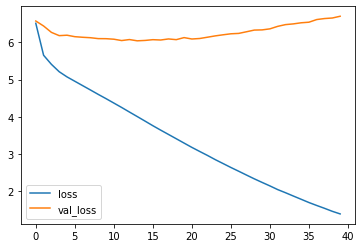

In [45]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [47]:
model.save('s2s.h5')

In [48]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [49]:
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

In [50]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [51]:
def decode_sequence(input_seq):
  states_value = encoder_model.predict(input_seq)
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = word2idx_outputs['<sos>']
  eos = word2idx_outputs['<eos>']
  output_sentence = []
  
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )

    idx = np.argmax(output_tokens[0, 0, :])

    if eos == idx:
      break

    word = ''
    
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)
    
    target_seq[0, 0] = idx
    states_value = [h, c]

  return ' '.join(output_sentence)

In [52]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break


-
Input: He began to shout.
Translation: वह चिल्लाने लगा।
Continue? [Y/n]Y
-
Input: India has a different climate from England.
Translation: भारत में बहुत उगाई जाती है।
Continue? [Y/n]Y
-
Input: Let him in.
Translation: उसे अंदर भेजो।
Continue? [Y/n]Y
-
Input: She is as beautiful as her mother.
Translation: वह अपनी माँ को सुंदर है।
Continue? [Y/n]n
